In [1]:
from __future__ import division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
import time
import os

from ops import *
from utils import *

In [2]:
%pylab inline
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


C:\Users\MachineLearningUser\AppData\Local\conda\conda\envs\ml\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', 'imsave', 'imread']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
%load_ext tensorboard

In [4]:
import tensorboard
tensorboard.__version__

'1.15.0'

Today we are going to train GAN for generating faces and then we will make fun playing with it. Generative adversarial networks (GANs) are deep neural net architectures comprised of two nets, pitting one against the other (thus the “adversarial”). One neural network, called the generator, generates new faces, while the other, the discriminator,  decides whether each instance of face it reviews belongs to the actual training dataset or not.

Firstly download aligned faces of celebrities from here <a href="https://yadi.sk/d/xjuClJJH3MAVXh">link</a> and extract them into folder near ipython notebook.

# Implementation of GAN

Constant variables below depends on your dataset and choosing of architecture.

In [5]:
DATA_PATH = './aligned_celebA/' # Path to the dataset with celebA faces
Z_DIM = 128 # Dimension of face's manifold
GENERATOR_DENSE_SIZE = 1024 # Length of first tensor in generator

IMAGE_SIZE = 64 # Shapes of input image
BATCH_SIZE = 128 # Batch size
N_CHANNELS = 3 # Number channels of input image

FLIP_LABEL_PROB = .1

In [6]:
assert(os.path.exists(DATA_PATH)), 'Please, download aligned celebA to DATA_PATH folder'

Let's define GAN. To do it, we need to define generator, discriminator and loss functions.

Here are some tips on the architecture of the generator:
1. The deeper is convolution, the less filters is using.
2. Apply deconvolutions-relu layers to achieve input image shape.
3. Use batch normalization before nonlinearity for speed and stability of learning.
4. Use tanh activation at the end of network (in this case images should be scaled to [-1, 1])
5. To force generator not to collapse and produce different outputs initialize bias with zero (see linear layer).

Other useful tips: https://github.com/soumith/ganhacks. Example of architecture see below. You may also use defined layers from ops.py. <b> Please, use names for layers started with "g\_" for generator and "d_" for discriminator.</b>

<img src="https://raw.githubusercontent.com/carpedm20/DCGAN-tensorflow/master/DCGAN.png">

## Writing generator function (1 point)

In [7]:
def generator(z, is_training):
    h_out = linear(z, GENERATOR_DENSE_SIZE * 4 * 4, 'g_h0_lin')
    h_out = batch_norm(name='g_bn0')(h_out)
    h_out = lrelu(h_out, leak=0.2, name="g_h0_lrelu")    
    h_out = tf.reshape(h_out, [-1, 4, 4, GENERATOR_DENSE_SIZE])
    
    h_out = deconv2d(h_out, [BATCH_SIZE, 4, 4, GENERATOR_DENSE_SIZE], name='g_h1_deconv', k_h=5, k_w=5, d_h=1, d_w=1, use_bias=False)
    h_out = batch_norm(name='g_bn1')(h_out)
    h_out = lrelu(h_out, leak=0.2, name="g_h1_lrelu")
    
    h_out = deconv2d(h_out, [BATCH_SIZE, 8, 8, 512], name='g_h2_deconv', k_h=5, k_w=5, d_h=2, d_w=2, use_bias=False)
    h_out = batch_norm(name='g_bn2')(h_out)
    h_out = lrelu(h_out, leak=0.2, name="g_h2_lrelu")
        
    h_out = deconv2d(h_out, [BATCH_SIZE, 16, 16, 256], name='g_h3_deconv', k_h=5, k_w=5, d_h=2, d_w=2, use_bias=False)
    h_out = batch_norm(name='g_bn3')(h_out)
    h_out = lrelu(h_out, leak=0.2, name="g_h3_lrelu")
    
    h_out = deconv2d(h_out, [BATCH_SIZE, 32, 32, 128], name='g_h4_deconv', use_bias=False)
    h_out = batch_norm(name='g_bn4')(h_out)
    h_out = lrelu(h_out, leak=0.2, name="g_h4_lrelu")
        
    h_out = deconv2d(h_out, [BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS], name='g_out')

    return tf.nn.tanh(h_out)

Now let's define discriminator. Discriminator takes 3d tensor as input and outputs one number - probability that this is an image.

Some advice for discriminator's architecture:
1. Use batch normalization between convolutions and nonlinearities.
2. Use leaky relu with the leak about 0.2.
3. The deeper the layer, the more filters you can use.

If you use batch normalization, please define every layer in their own scope and pass is_training parameter there. Or you may use class of batch normalization from ops.py. Do not forget to fratten tensor after the convolution blocks.

## Writing discriminator function (1 point)

In [8]:
def discriminator(image, is_training, batch_norms=None):
    
    h_out = image
    
    #h_out = tf.nn.dropout(h_out, 0.1)
    
    h_out = conv2d(h_out, output_dim = 128, k_h = 5, k_w = 5, d_h = 2, d_w = 2, stddev=0.02, name="d_h0_conv")
    if batch_norms is not None and len(batch_norms) > 0:
        h_out = batch_norms[0](h_out)
    h_out = lrelu(h_out, leak=0.2, name="d_h0_lrelu")
    h_out = tf.nn.dropout(h_out, 0.3)
    
    h_out = conv2d(h_out, output_dim = 256, k_h = 5, k_w = 5, d_h = 2, d_w = 2, stddev=0.02, name="d_h1_conv")
    if batch_norms is not None and len(batch_norms) > 1:
        h_out = batch_norms[1](h_out)
    h_out = lrelu(h_out, leak=0.2, name="d_h1_lrelu")
    h_out = tf.nn.dropout(h_out, 0.3)
    
    h_out = conv2d(h_out, output_dim = 512, k_h = 5, k_w = 5, d_h = 2, d_w = 2, stddev=0.02, name="d_h2_conv")
    if batch_norms is not None and len(batch_norms) > 2:
        h_out = batch_norms[2](h_out)
    h_out = lrelu(h_out, leak=0.2, name="d_h2_lrelu")
    h_out = tf.nn.dropout(h_out, 0.2)
    
    h_out = conv2d(h_out, output_dim = 1024, k_h = 5, k_w = 5, d_h = 2, d_w = 2, stddev=0.02, name="d_h3_conv")
    if batch_norms is not None and len(batch_norms) > 3:
        h_out = batch_norms[3](h_out)
    h_out = lrelu(h_out, leak=0.2, name="d_h3_lrelu")
    h_out = tf.nn.dropout(h_out, 0.2)
    
    shape = h_out.get_shape().as_list()    
    h_out = tf.reshape(h_out, [-1, np.prod(shape[1:])])
    
    h_out = linear(h_out, 1024*2, 'd_h4_lin')
    h_out = lrelu(h_out, leak=0.2, name="d_h4_lrelu")
    h_out = tf.nn.dropout(h_out, 0.1)
    
    h_out = linear(h_out, 1024, 'd_h5_lin')
    h_out = lrelu(h_out, leak=0.2, name="d_h5_lrelu")
    h_out = tf.nn.dropout(h_out, 0.1)
    
    h_out = linear(h_out, 1024, 'd_h6_lin')
    h_out = lrelu(h_out, leak=0.2, name="d_h6_lrelu")
    h_out = tf.nn.dropout(h_out, 0.1)
    
    linear_out = linear(h_out, 1, 'd_h7_lin')
    
    return tf.nn.sigmoid(linear_out), linear_out

Now let's define generator and discriminator.

In [9]:
tf.reset_default_graph()
is_training = tf.placeholder(tf.bool, name='is_training')

with tf.variable_scope("G") as scope:
    z = tf.placeholder(tf.float32, [None, Z_DIM], name='z')
    G = generator(z, is_training)

with tf.variable_scope('D') as scope:
    images = tf.placeholder(tf.float32, shape=[None, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS])
    real_labels = tf.placeholder(tf.float32, shape=[None, 1])
    fake_labels = tf.placeholder(tf.float32, shape=[None, 1])
    
    #batch_norms = [   batch_norm(name='d_bn0'),
    #                  batch_norm(name='d_bn1'),
    #                  batch_norm(name='d_bn2'),
    #                  batch_norm(name='d_bn3') ]
    
    D_real, D_real_logits = discriminator(images, is_training, 
                                          batch_norms = None)
    
    scope.reuse_variables()
    D_fake, D_fake_logits = discriminator(G, is_training, 
                                          batch_norms = None)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [10]:
G

<tf.Tensor 'G/Tanh:0' shape=(128, 64, 64, 3) dtype=float32>

In [11]:
D_fake, D_fake_logits

(<tf.Tensor 'D/Sigmoid_1:0' shape=(128, 1) dtype=float32>,
 <tf.Tensor 'D/d_h7_lin_1/add:0' shape=(128, 1) dtype=float32>)

Write definition of loss funstions according to formulas:
$$ D\_loss = \frac{-1}{m} \sum_{i=1}^{m}[\log{D(x_i)} + \log{(1 - D(G(z_i)))}]$$
$$ G\_loss = \frac{1}{m} \sum_{i=1}^{m} \log{(1 - D(G(z_i)))}$$

Or for better learning you may try other loss for generator:
$$ G\_loss = \frac{-1}{m} \sum_{i=1}^{m} \log{(D(G(z_i)))}$$

## Writing loss functions (2 points)

In [12]:
d_loss_real = -tf.reduce_mean( tf.log(D_real) * real_labels  )

d_loss_fake = -tf.reduce_mean( tf.log(1. - D_fake) * (1. - fake_labels) )

#d_loss = d_loss_real + d_loss_fake
#d_loss = -tf.reduce_mean( tf.log(D_real) + tf.log(1. - D_fake) )

g_loss = -tf.reduce_mean(tf.log(D_fake))
#g_loss = tf.reduce_mean(tf.log(1. - D_fake))

Create optimizers. We use different optimizers for discriminator and generator, so we needed a separate prefix for the discriminator and generator variables (g_ for generator, d_ for disciminator).

In [13]:
tvars = tf.trainable_variables()
## All variables of discriminator
d_vars = [v for v in tvars if 'd_' in v.name]
print("D params:", np.sum([ np.prod(v.get_shape().as_list()) for v in d_vars ]) )

## All variables of generator
g_vars = [v for v in tvars if 'g_' in v.name]
print("G params:", np.sum([ np.prod(v.get_shape().as_list()) for v in g_vars ]) )

LEARNING_RATE = 0.00001 # Learning rate for adam optimizer
BETA = 0.8 # Beta paramater in adam optimizer

##Optimizers - ypu may use your favourite instead.
#d_optim = tf.train.AdamOptimizer(LEARNING_RATE, beta1=BETA) \
#                  .minimize(d_loss, var_list=d_vars)
d_real_optim = tf.train.AdamOptimizer(LEARNING_RATE, beta1=BETA) \
                  .minimize(d_loss_real, var_list=d_vars)
d_fake_optim = tf.train.AdamOptimizer(LEARNING_RATE, beta1=BETA) \
                  .minimize(d_loss_fake, var_list=d_vars)
# SGD for discriminator 

g_optim = tf.train.AdamOptimizer(LEARNING_RATE, beta1=BETA) \
                  .minimize(g_loss, var_list=g_vars) 

D params: 53920001
G params: 45577347


Load data:

In [14]:
data = glob(os.path.join(DATA_PATH, "*.jpg"))
assert(len(data) > 0), "Length of training data should be more than zero"

In [15]:
img = get_image(data[0], IMAGE_SIZE)

In [16]:
np.min(img), np.max(img)

(-1.0, 0.9921568627450981)

In [17]:
img = inverse_transform([img])[0]

In [18]:
img.shape

(64, 64, 3)

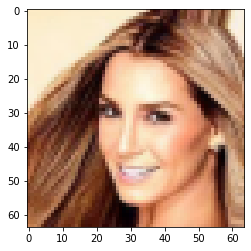

In [19]:
plt.imshow(img)

In [20]:
with tf.Session() as sess:
    op = sess.graph.get_operations()
    for m in op:
        print( m.values() )

(<tf.Tensor 'is_training:0' shape=<unknown> dtype=bool>,)
(<tf.Tensor 'G/z:0' shape=(?, 128) dtype=float32>,)
(<tf.Tensor 'G/g_h0_lin/Matrix/Initializer/random_normal/shape:0' shape=(2,) dtype=int32>,)
(<tf.Tensor 'G/g_h0_lin/Matrix/Initializer/random_normal/mean:0' shape=() dtype=float32>,)
(<tf.Tensor 'G/g_h0_lin/Matrix/Initializer/random_normal/stddev:0' shape=() dtype=float32>,)
(<tf.Tensor 'G/g_h0_lin/Matrix/Initializer/random_normal/RandomStandardNormal:0' shape=(128, 16384) dtype=float32>,)
(<tf.Tensor 'G/g_h0_lin/Matrix/Initializer/random_normal/mul:0' shape=(128, 16384) dtype=float32>,)
(<tf.Tensor 'G/g_h0_lin/Matrix/Initializer/random_normal:0' shape=(128, 16384) dtype=float32>,)
(<tf.Tensor 'G/g_h0_lin/Matrix:0' shape=(128, 16384) dtype=float32_ref>,)
(<tf.Tensor 'G/g_h0_lin/Matrix/Assign:0' shape=(128, 16384) dtype=float32_ref>,)
(<tf.Tensor 'G/g_h0_lin/Matrix/read:0' shape=(128, 16384) dtype=float32>,)
(<tf.Tensor 'G/g_h0_lin/bias/Initializer/Const:0' shape=(16384,) dtype=

(<tf.Tensor 'gradients_1/D/d_h6_lrelu_1/mul_grad/Sum/reduction_indices:0' shape=(2,) dtype=int32>,)
(<tf.Tensor 'gradients_1/D/d_h6_lrelu_1/mul_grad/Sum:0' shape=() dtype=float32>,)
(<tf.Tensor 'gradients_1/D/d_h6_lrelu_1/mul_grad/Reshape/shape:0' shape=(0,) dtype=int32>,)
(<tf.Tensor 'gradients_1/D/d_h6_lrelu_1/mul_grad/Reshape:0' shape=() dtype=float32>,)
(<tf.Tensor 'gradients_1/D/d_h6_lrelu_1/mul_grad/Mul_1:0' shape=(128, 1024) dtype=float32>,)
()
(<tf.Tensor 'gradients_1/D/d_h6_lrelu_1/mul_grad/tuple/control_dependency:0' shape=() dtype=float32>,)
(<tf.Tensor 'gradients_1/D/d_h6_lrelu_1/mul_grad/tuple/control_dependency_1:0' shape=(128, 1024) dtype=float32>,)
(<tf.Tensor 'gradients_1/D/d_h6_lrelu_1/mul_1_grad/Mul:0' shape=(128, 1024) dtype=float32>,)
(<tf.Tensor 'gradients_1/D/d_h6_lrelu_1/mul_1_grad/Sum/reduction_indices:0' shape=(2,) dtype=int32>,)
(<tf.Tensor 'gradients_1/D/d_h6_lrelu_1/mul_1_grad/Sum:0' shape=() dtype=float32>,)
(<tf.Tensor 'gradients_1/D/d_h6_lrelu_1/mul_1_gr

(<tf.Tensor 'G/g_bn4/beta/Adam/Initializer/zeros:0' shape=(128,) dtype=float32>,)
(<tf.Tensor 'G/g_bn4/beta/Adam:0' shape=(128,) dtype=float32_ref>,)
(<tf.Tensor 'G/g_bn4/beta/Adam/Assign:0' shape=(128,) dtype=float32_ref>,)
(<tf.Tensor 'G/g_bn4/beta/Adam/read:0' shape=(128,) dtype=float32>,)
(<tf.Tensor 'G/g_bn4/beta/Adam_1/Initializer/zeros:0' shape=(128,) dtype=float32>,)
(<tf.Tensor 'G/g_bn4/beta/Adam_1:0' shape=(128,) dtype=float32_ref>,)
(<tf.Tensor 'G/g_bn4/beta/Adam_1/Assign:0' shape=(128,) dtype=float32_ref>,)
(<tf.Tensor 'G/g_bn4/beta/Adam_1/read:0' shape=(128,) dtype=float32>,)
(<tf.Tensor 'G/g_bn4/gamma/Adam/Initializer/zeros:0' shape=(128,) dtype=float32>,)
(<tf.Tensor 'G/g_bn4/gamma/Adam:0' shape=(128,) dtype=float32_ref>,)
(<tf.Tensor 'G/g_bn4/gamma/Adam/Assign:0' shape=(128,) dtype=float32_ref>,)
(<tf.Tensor 'G/g_bn4/gamma/Adam/read:0' shape=(128,) dtype=float32>,)
(<tf.Tensor 'G/g_bn4/gamma/Adam_1/Initializer/zeros:0' shape=(128,) dtype=float32>,)
(<tf.Tensor 'G/g_bn4/

Functions for training and evaluations.

In [21]:
def load(sess, load_dir):
    """load network's paramaters
    
    load_dir : path to load dir
    """
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state(load_dir)
    if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)

## Training GAN (1 point + 2 for good results)

In [22]:
def train(sess, load_dir=None, save_frequency=100, sample_frequency=100, sample_dir='sample_faces',
          save_dir='checkpoint', max_to_keep=1, model_name='dcgan.model',
          n_epochs=25, n_generator_update=2):
    """train gan
    Parameters
    -------------------------------------------
    load_dir : str, default = None
        path to the folder with parameters
    save_frequency: int, default = 100
        how often save parameters []
    sample_frequency: int, default = None (not sample)
        how often sample faces
    sample_dir: str, default = samples
        directory for sampled images
    save_dir: str, default = 'checkpoint'
        path where to save parameters
    max_to_keep: int, default = 1
        how many last checkpoints to store
    model_name: str, default='dcgan.model'
        name of model
    n_epochs: int, default = 25 
        number epochs to train
    n_generator_update: int, default = 2
        how many times run generator updates per one discriminator update
    -------------------------------------------
    """
    
    if save_frequency is not None:
        saver = tf.train.Saver(max_to_keep=max_to_keep)
        
    if load_dir is not None:
        print("Reading checkpoints...")
        load(sess, load_dir)
        print("Loaded checkpoints")
    else:
        try:
            tf.global_variables_initializer().run()
        except:
            tf.initialize_all_variables().run()

    counter=1
    start_time = time.time()
    
    for epoch in range(n_epochs):
        batch_idxs = min(len(data), np.inf) // BATCH_SIZE
        for idx in range(batch_idxs):
            batch_files = data[idx*BATCH_SIZE:(idx+1)*BATCH_SIZE]
            
            batch = [ get_image(batch_file, IMAGE_SIZE) for batch_file in batch_files ]
            batch_images = np.array(batch).astype(np.float32)
            
            batch_real_labels = np.random.uniform(.7, 1.2, [BATCH_SIZE, 1]).astype(np.float32)            
            batch_fake_labels = np.random.uniform(0., .3, [BATCH_SIZE, 1]).astype(np.float32)
            
            label_flip_choices = np.random.uniform(0., 1., BATCH_SIZE)
            for label_i in range(BATCH_SIZE):
                if label_flip_choices[label_i] < FLIP_LABEL_PROB:
                    batch_real_labels[label_i], batch_fake_labels[label_i] = batch_fake_labels[label_i], batch_real_labels[label_i]
                        
            #batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)
            batch_z = np.random.normal(size=(BATCH_SIZE, Z_DIM)).astype(np.float32)

            # Update D network
            #sess.run(d_optim, feed_dict={images: batch_images, z: batch_z,is_training: True})
            sess.run(d_real_optim, feed_dict={ images: batch_images, real_labels: batch_real_labels, is_training: True})
            sess.run(d_fake_optim, feed_dict={ z: batch_z, fake_labels: batch_fake_labels, is_training: True})

            # Update G network
            for _ in range(n_generator_update):
                #batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)
                batch_z = np.random.normal(size=(BATCH_SIZE, Z_DIM)).astype(np.float32)
                sess.run(g_optim, feed_dict={z: batch_z, is_training: True})

            errD_fake = d_loss_fake.eval({z: batch_z, fake_labels: batch_fake_labels, is_training: False})
            errD_real = d_loss_real.eval({images: batch_images, real_labels: batch_real_labels, is_training: False})
            errG = g_loss.eval({z: batch_z, is_training: False})

            counter += 1
            print("Epoch: [{:2d}] [{:4d}/{:4d}] time: {:4.4f}, d_loss: {:.8f}, g_loss: {:.8f}".format(
                epoch, idx, batch_idxs, time.time() - start_time, errD_fake+errD_real, errG))

            if np.mod(counter, save_frequency) == 1:
                print("Saved model")
                saver.save(sess,
                           os.path.join(save_dir, '{}_{:02d}_{:04d}'.format(model_name, epoch, idx)))

            if np.mod(counter, sample_frequency) == 1:
                samples = sess.run(G, feed_dict={z: batch_z, is_training: False} )
                print(samples.shape)
                save_images(samples[:25], None, os.path.join(sample_dir, 'train_{:02d}_{:04d}.png'.format(epoch, idx)) )
                print("Sample")

In [23]:
with tf.Session() as sess:
    train(sess, save_dir='checkpoint', n_epochs=100, sample_frequency=100, n_generator_update=2, max_to_keep=20)

Epoch: [ 0] [   0/1582] time: 5.1904, d_loss: 1.18162453, g_loss: 0.67074358
Epoch: [ 0] [   1/1582] time: 6.4268, d_loss: 1.22052860, g_loss: 0.67773741
Epoch: [ 0] [   2/1582] time: 7.6598, d_loss: 1.15169477, g_loss: 0.67253828
Epoch: [ 0] [   3/1582] time: 8.8927, d_loss: 1.15027094, g_loss: 0.67159033
Epoch: [ 0] [   4/1582] time: 10.1317, d_loss: 1.19046164, g_loss: 0.68360430
Epoch: [ 0] [   5/1582] time: 11.3669, d_loss: 1.16520810, g_loss: 0.68026257
Epoch: [ 0] [   6/1582] time: 12.6029, d_loss: 1.16165936, g_loss: 0.68518454
Epoch: [ 0] [   7/1582] time: 13.8368, d_loss: 1.14737213, g_loss: 0.68087637
Epoch: [ 0] [   8/1582] time: 15.0738, d_loss: 1.14744163, g_loss: 0.67856121
Epoch: [ 0] [   9/1582] time: 16.3073, d_loss: 1.18219256, g_loss: 0.68423128
Epoch: [ 0] [  10/1582] time: 17.5423, d_loss: 1.16078436, g_loss: 0.68116051
Epoch: [ 0] [  11/1582] time: 18.7762, d_loss: 1.15791821, g_loss: 0.67726004
Epoch: [ 0] [  12/1582] time: 20.0122, d_loss: 1.16003680, g_loss: 0

Epoch: [ 0] [ 105/1582] time: 142.8428, d_loss: 1.10346270, g_loss: 0.68385148
Epoch: [ 0] [ 106/1582] time: 144.0837, d_loss: 1.15531361, g_loss: 0.68581414
Epoch: [ 0] [ 107/1582] time: 145.3207, d_loss: 1.15534449, g_loss: 0.68559927
Epoch: [ 0] [ 108/1582] time: 146.5577, d_loss: 1.14943707, g_loss: 0.68375796
Epoch: [ 0] [ 109/1582] time: 147.7956, d_loss: 1.13648915, g_loss: 0.68419731
Epoch: [ 0] [ 110/1582] time: 149.0346, d_loss: 1.15031648, g_loss: 0.68516284
Epoch: [ 0] [ 111/1582] time: 150.2745, d_loss: 1.12051630, g_loss: 0.68048072
Epoch: [ 0] [ 112/1582] time: 151.5135, d_loss: 1.12262523, g_loss: 0.68476593
Epoch: [ 0] [ 113/1582] time: 152.7534, d_loss: 1.13052702, g_loss: 0.68237877
Epoch: [ 0] [ 114/1582] time: 153.9914, d_loss: 1.13912201, g_loss: 0.69074619
Epoch: [ 0] [ 115/1582] time: 155.2341, d_loss: 1.12456012, g_loss: 0.68456072
Epoch: [ 0] [ 116/1582] time: 156.4731, d_loss: 1.13979304, g_loss: 0.69260812
Epoch: [ 0] [ 117/1582] time: 157.7090, d_loss: 1.13

Epoch: [ 0] [ 209/1582] time: 278.4596, d_loss: 1.16597998, g_loss: 0.67679107
Epoch: [ 0] [ 210/1582] time: 279.6986, d_loss: 1.17853451, g_loss: 0.68434989
Epoch: [ 0] [ 211/1582] time: 280.9391, d_loss: 1.18922830, g_loss: 0.68101978
Epoch: [ 0] [ 212/1582] time: 282.1784, d_loss: 1.17867196, g_loss: 0.68034935
Epoch: [ 0] [ 213/1582] time: 283.4166, d_loss: 1.16827607, g_loss: 0.67939562
Epoch: [ 0] [ 214/1582] time: 284.6565, d_loss: 1.19244826, g_loss: 0.67670089
Epoch: [ 0] [ 215/1582] time: 285.8937, d_loss: 1.17092586, g_loss: 0.68494320
Epoch: [ 0] [ 216/1582] time: 287.1327, d_loss: 1.17224264, g_loss: 0.68044376
Epoch: [ 0] [ 217/1582] time: 288.3718, d_loss: 1.17704058, g_loss: 0.68701273
Epoch: [ 0] [ 218/1582] time: 289.6097, d_loss: 1.16248417, g_loss: 0.68111432
Epoch: [ 0] [ 219/1582] time: 290.8452, d_loss: 1.17824864, g_loss: 0.68536806
Epoch: [ 0] [ 220/1582] time: 292.0842, d_loss: 1.14083695, g_loss: 0.68459260
Epoch: [ 0] [ 221/1582] time: 293.3221, d_loss: 1.17

Epoch: [ 0] [ 313/1582] time: 414.2115, d_loss: 1.16962898, g_loss: 0.68647897
Epoch: [ 0] [ 314/1582] time: 415.4505, d_loss: 1.17716646, g_loss: 0.68762982
Epoch: [ 0] [ 315/1582] time: 416.6896, d_loss: 1.18406296, g_loss: 0.68686986
Epoch: [ 0] [ 316/1582] time: 417.9306, d_loss: 1.18184662, g_loss: 0.68964267
Epoch: [ 0] [ 317/1582] time: 419.1725, d_loss: 1.19265473, g_loss: 0.69316924
Epoch: [ 0] [ 318/1582] time: 420.4135, d_loss: 1.20084918, g_loss: 0.69109935
Epoch: [ 0] [ 319/1582] time: 421.6534, d_loss: 1.17292380, g_loss: 0.69171715
Epoch: [ 0] [ 320/1582] time: 422.8914, d_loss: 1.17195320, g_loss: 0.68803155
Epoch: [ 0] [ 321/1582] time: 424.1333, d_loss: 1.15764940, g_loss: 0.69213128
Epoch: [ 0] [ 322/1582] time: 425.3713, d_loss: 1.16969275, g_loss: 0.69311112
Epoch: [ 0] [ 323/1582] time: 426.6092, d_loss: 1.18747997, g_loss: 0.69001859
Epoch: [ 0] [ 324/1582] time: 427.8512, d_loss: 1.16290474, g_loss: 0.69105291
Epoch: [ 0] [ 325/1582] time: 429.0912, d_loss: 1.14

Epoch: [ 0] [ 417/1582] time: 549.8463, d_loss: 1.15876818, g_loss: 0.72207701
Epoch: [ 0] [ 418/1582] time: 551.0923, d_loss: 1.13278675, g_loss: 0.71913660
Epoch: [ 0] [ 419/1582] time: 552.3343, d_loss: 1.13455820, g_loss: 0.72510189
Epoch: [ 0] [ 420/1582] time: 553.5762, d_loss: 1.15108991, g_loss: 0.72917193
Epoch: [ 0] [ 421/1582] time: 554.8201, d_loss: 1.17113924, g_loss: 0.73256224
Epoch: [ 0] [ 422/1582] time: 556.0611, d_loss: 1.15244293, g_loss: 0.73239183
Epoch: [ 0] [ 423/1582] time: 557.3051, d_loss: 1.11824298, g_loss: 0.73457313
Epoch: [ 0] [ 424/1582] time: 558.5470, d_loss: 1.17888379, g_loss: 0.73269540
Epoch: [ 0] [ 425/1582] time: 559.7895, d_loss: 1.16652548, g_loss: 0.73746675
Epoch: [ 0] [ 426/1582] time: 561.0314, d_loss: 1.18069220, g_loss: 0.73090023
Epoch: [ 0] [ 427/1582] time: 562.2724, d_loss: 1.15992546, g_loss: 0.73405999
Epoch: [ 0] [ 428/1582] time: 563.5143, d_loss: 1.15455842, g_loss: 0.73208594
Epoch: [ 0] [ 429/1582] time: 564.7573, d_loss: 1.16

Epoch: [ 0] [ 521/1582] time: 685.7057, d_loss: 1.18248010, g_loss: 0.71427149
Epoch: [ 0] [ 522/1582] time: 686.9466, d_loss: 1.15630269, g_loss: 0.71567953
Epoch: [ 0] [ 523/1582] time: 688.1886, d_loss: 1.17857552, g_loss: 0.72160941
Epoch: [ 0] [ 524/1582] time: 689.4315, d_loss: 1.18265200, g_loss: 0.72718877
Epoch: [ 0] [ 525/1582] time: 690.6775, d_loss: 1.14309955, g_loss: 0.73077095
Epoch: [ 0] [ 526/1582] time: 691.9202, d_loss: 1.16378307, g_loss: 0.73178470
Epoch: [ 0] [ 527/1582] time: 693.1644, d_loss: 1.17593813, g_loss: 0.73690110
Epoch: [ 0] [ 528/1582] time: 694.4063, d_loss: 1.15751767, g_loss: 0.73602206
Epoch: [ 0] [ 529/1582] time: 695.6503, d_loss: 1.15647388, g_loss: 0.73616344
Epoch: [ 0] [ 530/1582] time: 696.8943, d_loss: 1.15356278, g_loss: 0.73769283
Epoch: [ 0] [ 531/1582] time: 698.1392, d_loss: 1.13941097, g_loss: 0.73929632
Epoch: [ 0] [ 532/1582] time: 699.3812, d_loss: 1.15341079, g_loss: 0.73690200
Epoch: [ 0] [ 533/1582] time: 700.6269, d_loss: 1.19

Epoch: [ 0] [ 625/1582] time: 821.6395, d_loss: 1.20994544, g_loss: 0.69499451
Epoch: [ 0] [ 626/1582] time: 822.8914, d_loss: 1.17601657, g_loss: 0.69939047
Epoch: [ 0] [ 627/1582] time: 824.1414, d_loss: 1.16822815, g_loss: 0.69943094
Epoch: [ 0] [ 628/1582] time: 825.3984, d_loss: 1.18081617, g_loss: 0.70591170
Epoch: [ 0] [ 629/1582] time: 826.6403, d_loss: 1.19175792, g_loss: 0.70791137
Epoch: [ 0] [ 630/1582] time: 827.8853, d_loss: 1.19764805, g_loss: 0.71234256
Epoch: [ 0] [ 631/1582] time: 829.1299, d_loss: 1.15976119, g_loss: 0.72025484
Epoch: [ 0] [ 632/1582] time: 830.3732, d_loss: 1.19322288, g_loss: 0.72304958
Epoch: [ 0] [ 633/1582] time: 831.6152, d_loss: 1.18136311, g_loss: 0.72387350
Epoch: [ 0] [ 634/1582] time: 832.8601, d_loss: 1.16434002, g_loss: 0.72178710
Epoch: [ 0] [ 635/1582] time: 834.1048, d_loss: 1.18514550, g_loss: 0.72709733
Epoch: [ 0] [ 636/1582] time: 835.3488, d_loss: 1.16033900, g_loss: 0.72948432
Epoch: [ 0] [ 637/1582] time: 836.5947, d_loss: 1.20

Epoch: [ 0] [ 729/1582] time: 957.8179, d_loss: 1.14875400, g_loss: 0.74842656
Epoch: [ 0] [ 730/1582] time: 959.0609, d_loss: 1.15116405, g_loss: 0.74996829
Epoch: [ 0] [ 731/1582] time: 960.3010, d_loss: 1.17843294, g_loss: 0.74398911
Epoch: [ 0] [ 732/1582] time: 961.5469, d_loss: 1.15485024, g_loss: 0.73957086
Epoch: [ 0] [ 733/1582] time: 962.7838, d_loss: 1.16949356, g_loss: 0.73588079
Epoch: [ 0] [ 734/1582] time: 964.0273, d_loss: 1.18173099, g_loss: 0.72793257
Epoch: [ 0] [ 735/1582] time: 965.2726, d_loss: 1.17899561, g_loss: 0.72202998
Epoch: [ 0] [ 736/1582] time: 966.5166, d_loss: 1.20550656, g_loss: 0.71499616
Epoch: [ 0] [ 737/1582] time: 967.7616, d_loss: 1.19153512, g_loss: 0.70246500
Epoch: [ 0] [ 738/1582] time: 969.0055, d_loss: 1.20596600, g_loss: 0.69568568
Epoch: [ 0] [ 739/1582] time: 970.2524, d_loss: 1.16849172, g_loss: 0.68576384
Epoch: [ 0] [ 740/1582] time: 971.4974, d_loss: 1.16471577, g_loss: 0.68157369
Epoch: [ 0] [ 741/1582] time: 972.7417, d_loss: 1.19

Epoch: [ 0] [ 832/1582] time: 1092.5572, d_loss: 1.21641123, g_loss: 0.61982608
Epoch: [ 0] [ 833/1582] time: 1093.7982, d_loss: 1.24490166, g_loss: 0.64826357
Epoch: [ 0] [ 834/1582] time: 1095.0412, d_loss: 1.17319238, g_loss: 0.68028563
Epoch: [ 0] [ 835/1582] time: 1096.2821, d_loss: 1.15339923, g_loss: 0.70689547
Epoch: [ 0] [ 836/1582] time: 1097.5241, d_loss: 1.09054208, g_loss: 0.72367632
Epoch: [ 0] [ 837/1582] time: 1098.7656, d_loss: 1.10994864, g_loss: 0.74731779
Epoch: [ 0] [ 838/1582] time: 1100.0085, d_loss: 1.15080667, g_loss: 0.75634390
Epoch: [ 0] [ 839/1582] time: 1101.2487, d_loss: 1.09678233, g_loss: 0.76722872
Epoch: [ 0] [ 840/1582] time: 1102.4887, d_loss: 1.12706685, g_loss: 0.77683377
Epoch: [ 0] [ 841/1582] time: 1103.7297, d_loss: 1.06453204, g_loss: 0.77502751
Epoch: [ 0] [ 842/1582] time: 1104.9696, d_loss: 1.04950643, g_loss: 0.78685129
Epoch: [ 0] [ 843/1582] time: 1106.2105, d_loss: 1.04332936, g_loss: 0.79170954
Epoch: [ 0] [ 844/1582] time: 1107.4515,

Epoch: [ 0] [ 934/1582] time: 1225.7742, d_loss: 1.12928474, g_loss: 0.78741586
Epoch: [ 0] [ 935/1582] time: 1227.0161, d_loss: 1.09755588, g_loss: 0.77999818
Epoch: [ 0] [ 936/1582] time: 1228.2620, d_loss: 1.10522258, g_loss: 0.76836574
Epoch: [ 0] [ 937/1582] time: 1229.5029, d_loss: 1.10266542, g_loss: 0.76312554
Epoch: [ 0] [ 938/1582] time: 1230.7439, d_loss: 1.12522733, g_loss: 0.74298513
Epoch: [ 0] [ 939/1582] time: 1231.9848, d_loss: 1.14828932, g_loss: 0.72837484
Epoch: [ 0] [ 940/1582] time: 1233.2286, d_loss: 1.15785170, g_loss: 0.71146500
Epoch: [ 0] [ 941/1582] time: 1234.4696, d_loss: 1.12057567, g_loss: 0.69568843
Epoch: [ 0] [ 942/1582] time: 1235.7125, d_loss: 1.18195271, g_loss: 0.67709750
Epoch: [ 0] [ 943/1582] time: 1236.9555, d_loss: 1.17248130, g_loss: 0.66266823
Epoch: [ 0] [ 944/1582] time: 1238.1995, d_loss: 1.16603017, g_loss: 0.64422357
Epoch: [ 0] [ 945/1582] time: 1239.4424, d_loss: 1.15485287, g_loss: 0.63251698
Epoch: [ 0] [ 946/1582] time: 1240.6854,

Epoch: [ 0] [1036/1582] time: 1359.0952, d_loss: 0.99297321, g_loss: 0.78732234
Epoch: [ 0] [1037/1582] time: 1360.3359, d_loss: 1.08011842, g_loss: 0.64971954
Epoch: [ 0] [1038/1582] time: 1361.5772, d_loss: 1.33601546, g_loss: 0.47128269
Epoch: [ 0] [1039/1582] time: 1362.8187, d_loss: 1.62560010, g_loss: 0.32371908
Epoch: [ 0] [1040/1582] time: 1364.0627, d_loss: 1.71280956, g_loss: 0.28459096
Epoch: [ 0] [1041/1582] time: 1365.3072, d_loss: 1.64111698, g_loss: 0.34760323
Epoch: [ 0] [1042/1582] time: 1366.5511, d_loss: 1.37185311, g_loss: 0.51996672
Epoch: [ 0] [1043/1582] time: 1367.7931, d_loss: 1.08852720, g_loss: 0.78561872
Epoch: [ 0] [1044/1582] time: 1369.0370, d_loss: 0.95341861, g_loss: 1.12863755
Epoch: [ 0] [1045/1582] time: 1370.2792, d_loss: 0.88080585, g_loss: 1.35735059
Epoch: [ 0] [1046/1582] time: 1371.5222, d_loss: 0.73918766, g_loss: 1.49758506
Epoch: [ 0] [1047/1582] time: 1372.7692, d_loss: 0.75105488, g_loss: 1.52122235
Epoch: [ 0] [1048/1582] time: 1374.0121,

Epoch: [ 0] [1138/1582] time: 1492.5005, d_loss: 0.84552860, g_loss: 0.79881150
Epoch: [ 0] [1139/1582] time: 1493.7425, d_loss: 0.76109505, g_loss: 0.80418140
Epoch: [ 0] [1140/1582] time: 1494.9879, d_loss: 0.76986694, g_loss: 0.81681383
Epoch: [ 0] [1141/1582] time: 1496.2285, d_loss: 0.76020265, g_loss: 0.82734674
Epoch: [ 0] [1142/1582] time: 1497.4715, d_loss: 0.76626110, g_loss: 0.83077914
Epoch: [ 0] [1143/1582] time: 1498.7167, d_loss: 0.72641546, g_loss: 0.83897406
Epoch: [ 0] [1144/1582] time: 1499.9616, d_loss: 0.75826061, g_loss: 0.83661681
Epoch: [ 0] [1145/1582] time: 1501.2056, d_loss: 0.73472977, g_loss: 0.83428043
Epoch: [ 0] [1146/1582] time: 1502.4486, d_loss: 0.73882818, g_loss: 0.83229363
Epoch: [ 0] [1147/1582] time: 1503.6935, d_loss: 0.71914876, g_loss: 0.82342434
Epoch: [ 0] [1148/1582] time: 1504.9385, d_loss: 0.72391254, g_loss: 0.81268239
Epoch: [ 0] [1149/1582] time: 1506.1824, d_loss: 0.75779307, g_loss: 0.78783220
Epoch: [ 0] [1150/1582] time: 1507.4254,

Epoch: [ 0] [1240/1582] time: 1626.1946, d_loss: 1.38667917, g_loss: 0.40142182
Epoch: [ 0] [1241/1582] time: 1627.4405, d_loss: 1.26495337, g_loss: 0.45599630
Epoch: [ 0] [1242/1582] time: 1628.6840, d_loss: 1.13480592, g_loss: 0.53321517
Epoch: [ 0] [1243/1582] time: 1629.9340, d_loss: 1.09104025, g_loss: 0.62340111
Epoch: [ 0] [1244/1582] time: 1631.1820, d_loss: 0.98372918, g_loss: 0.73306000
Epoch: [ 0] [1245/1582] time: 1632.4269, d_loss: 0.94702375, g_loss: 0.84279406
Epoch: [ 0] [1246/1582] time: 1633.6738, d_loss: 0.68847513, g_loss: 0.94366050
Epoch: [ 0] [1247/1582] time: 1634.9158, d_loss: 0.76707518, g_loss: 1.03448117
Epoch: [ 0] [1248/1582] time: 1636.1628, d_loss: 0.69868934, g_loss: 1.08171034
Epoch: [ 0] [1249/1582] time: 1637.4100, d_loss: 0.66875565, g_loss: 1.12240338
Epoch: [ 0] [1250/1582] time: 1638.6571, d_loss: 0.60355663, g_loss: 1.10415554
Epoch: [ 0] [1251/1582] time: 1639.9021, d_loss: 0.64354146, g_loss: 1.09469938
Epoch: [ 0] [1252/1582] time: 1641.1504,

Epoch: [ 0] [1342/1582] time: 1759.8740, d_loss: 1.04069066, g_loss: 0.71566969
Epoch: [ 0] [1343/1582] time: 1761.1205, d_loss: 1.06308663, g_loss: 0.80408865
Epoch: [ 0] [1344/1582] time: 1762.3655, d_loss: 0.90716344, g_loss: 0.83444548
Epoch: [ 0] [1345/1582] time: 1763.6104, d_loss: 0.78424859, g_loss: 0.88917708
Epoch: [ 0] [1346/1582] time: 1764.8574, d_loss: 0.72036421, g_loss: 0.92990369
Epoch: [ 0] [1347/1582] time: 1766.1043, d_loss: 0.70166582, g_loss: 0.96918416
Epoch: [ 0] [1348/1582] time: 1767.3513, d_loss: 0.65444940, g_loss: 0.99053162
Epoch: [ 0] [1349/1582] time: 1768.5943, d_loss: 0.61487973, g_loss: 0.98678070
Epoch: [ 0] [1350/1582] time: 1769.8382, d_loss: 0.60548806, g_loss: 1.00269079
Epoch: [ 0] [1351/1582] time: 1771.0822, d_loss: 0.60794121, g_loss: 0.98932600
Epoch: [ 0] [1352/1582] time: 1772.3294, d_loss: 0.60355580, g_loss: 0.94648135
Epoch: [ 0] [1353/1582] time: 1773.5740, d_loss: 0.66130733, g_loss: 0.90320218
Epoch: [ 0] [1354/1582] time: 1774.8172,

Epoch: [ 0] [1444/1582] time: 1893.5082, d_loss: 0.59413165, g_loss: 1.60733843
Epoch: [ 0] [1445/1582] time: 1894.7511, d_loss: 0.60325754, g_loss: 1.44421601
Epoch: [ 0] [1446/1582] time: 1895.9981, d_loss: 0.65410572, g_loss: 1.15510023
Epoch: [ 0] [1447/1582] time: 1897.2441, d_loss: 0.70485109, g_loss: 0.96344620
Epoch: [ 0] [1448/1582] time: 1898.4910, d_loss: 0.77768540, g_loss: 0.77441120
Epoch: [ 0] [1449/1582] time: 1899.7380, d_loss: 0.89317477, g_loss: 0.59886348
Epoch: [ 0] [1450/1582] time: 1900.9829, d_loss: 1.11346412, g_loss: 0.48550466
Epoch: [ 0] [1451/1582] time: 1902.2248, d_loss: 1.19071448, g_loss: 0.39831382
Epoch: [ 0] [1452/1582] time: 1903.4688, d_loss: 1.34575438, g_loss: 0.32291228
Epoch: [ 0] [1453/1582] time: 1904.7127, d_loss: 1.30230951, g_loss: 0.32228756
Epoch: [ 0] [1454/1582] time: 1905.9596, d_loss: 1.33125257, g_loss: 0.39828008
Epoch: [ 0] [1455/1582] time: 1907.2020, d_loss: 1.18430710, g_loss: 0.46611375
Epoch: [ 0] [1456/1582] time: 1908.4459,

Epoch: [ 0] [1546/1582] time: 2027.2581, d_loss: 0.33715779, g_loss: 1.58367848
Epoch: [ 0] [1547/1582] time: 2028.5020, d_loss: 0.39006150, g_loss: 1.50122380
Epoch: [ 0] [1548/1582] time: 2029.7460, d_loss: 0.37509182, g_loss: 1.43091464
Epoch: [ 0] [1549/1582] time: 2030.9921, d_loss: 0.44064382, g_loss: 1.32504380
Epoch: [ 0] [1550/1582] time: 2032.2351, d_loss: 0.52775908, g_loss: 1.26114345
Epoch: [ 0] [1551/1582] time: 2033.4800, d_loss: 0.51768756, g_loss: 1.23061848
Epoch: [ 0] [1552/1582] time: 2034.7250, d_loss: 0.63728553, g_loss: 1.13159657
Epoch: [ 0] [1553/1582] time: 2035.9699, d_loss: 0.66755295, g_loss: 1.05140996
Epoch: [ 0] [1554/1582] time: 2037.2151, d_loss: 0.64503872, g_loss: 1.10621190
Epoch: [ 0] [1555/1582] time: 2038.4591, d_loss: 0.43263555, g_loss: 1.29031646
Epoch: [ 0] [1556/1582] time: 2039.7040, d_loss: 0.67610329, g_loss: 1.35213256
Epoch: [ 0] [1557/1582] time: 2040.9490, d_loss: 0.48476207, g_loss: 1.46577311
Epoch: [ 0] [1558/1582] time: 2042.1937,

Epoch: [ 1] [  66/1582] time: 2161.0925, d_loss: 0.66627926, g_loss: 1.11345065
Epoch: [ 1] [  67/1582] time: 2162.3365, d_loss: 0.50581533, g_loss: 1.23284400
Epoch: [ 1] [  68/1582] time: 2163.5814, d_loss: 0.56185144, g_loss: 1.26041448
Epoch: [ 1] [  69/1582] time: 2164.8284, d_loss: 0.49514189, g_loss: 1.37444317
Epoch: [ 1] [  70/1582] time: 2166.0753, d_loss: 0.47913575, g_loss: 1.58327460
Epoch: [ 1] [  71/1582] time: 2167.3187, d_loss: 0.51624680, g_loss: 1.55606365
Epoch: [ 1] [  72/1582] time: 2168.5626, d_loss: 0.44433084, g_loss: 1.51977682
Epoch: [ 1] [  73/1582] time: 2169.8120, d_loss: 0.53332943, g_loss: 1.51087677
Epoch: [ 1] [  74/1582] time: 2171.0590, d_loss: 0.57028472, g_loss: 1.40361512
Epoch: [ 1] [  75/1582] time: 2172.3030, d_loss: 0.66745055, g_loss: 1.15025449
Epoch: [ 1] [  76/1582] time: 2173.5479, d_loss: 0.58847463, g_loss: 1.14727390
Epoch: [ 1] [  77/1582] time: 2174.7930, d_loss: 0.50387871, g_loss: 1.16821837
Epoch: [ 1] [  78/1582] time: 2176.0379,

Epoch: [ 1] [ 168/1582] time: 2294.6522, d_loss: 0.84013122, g_loss: 0.83594066
Epoch: [ 1] [ 169/1582] time: 2295.8981, d_loss: 0.67058623, g_loss: 0.89378214
Epoch: [ 1] [ 170/1582] time: 2297.1491, d_loss: 0.63703686, g_loss: 0.94862998
Epoch: [ 1] [ 171/1582] time: 2298.3970, d_loss: 0.59276569, g_loss: 0.97372323
Epoch: [ 1] [ 172/1582] time: 2299.6470, d_loss: 0.51906085, g_loss: 1.07269669
Epoch: [ 1] [ 173/1582] time: 2300.8989, d_loss: 0.55783314, g_loss: 1.12508214
Epoch: [ 1] [ 174/1582] time: 2302.1450, d_loss: 0.59106207, g_loss: 1.15933418
Epoch: [ 1] [ 175/1582] time: 2303.3900, d_loss: 0.48342556, g_loss: 1.20573759
Epoch: [ 1] [ 176/1582] time: 2304.6359, d_loss: 0.56245887, g_loss: 1.15565205
Epoch: [ 1] [ 177/1582] time: 2305.8846, d_loss: 0.52298927, g_loss: 1.19032788
Epoch: [ 1] [ 178/1582] time: 2307.1343, d_loss: 0.37731510, g_loss: 1.26384592
Epoch: [ 1] [ 179/1582] time: 2308.3823, d_loss: 0.37932497, g_loss: 1.35588384
Epoch: [ 1] [ 180/1582] time: 2309.6303,

Epoch: [ 1] [ 270/1582] time: 2428.5499, d_loss: 0.97273898, g_loss: 0.57552296
Epoch: [ 1] [ 271/1582] time: 2429.7958, d_loss: 0.86340350, g_loss: 0.63966262
Epoch: [ 1] [ 272/1582] time: 2431.0358, d_loss: 0.81268495, g_loss: 0.69049412
Epoch: [ 1] [ 273/1582] time: 2432.2787, d_loss: 0.81023216, g_loss: 0.73100597
Epoch: [ 1] [ 274/1582] time: 2433.5227, d_loss: 0.74518383, g_loss: 0.75025105
Epoch: [ 1] [ 275/1582] time: 2434.7667, d_loss: 0.65511167, g_loss: 0.78060734
Epoch: [ 1] [ 276/1582] time: 2436.0146, d_loss: 0.69314849, g_loss: 0.79957837
Epoch: [ 1] [ 277/1582] time: 2437.2596, d_loss: 0.61251289, g_loss: 0.82129848
Epoch: [ 1] [ 278/1582] time: 2438.5075, d_loss: 0.60724163, g_loss: 0.86126709
Epoch: [ 1] [ 279/1582] time: 2439.7535, d_loss: 0.61143720, g_loss: 0.87537801
Epoch: [ 1] [ 280/1582] time: 2440.9985, d_loss: 0.56021428, g_loss: 0.88113976
Epoch: [ 1] [ 281/1582] time: 2442.2434, d_loss: 0.59208286, g_loss: 0.89071286
Epoch: [ 1] [ 282/1582] time: 2443.4894,

Epoch: [ 1] [ 372/1582] time: 2562.3007, d_loss: 0.49879855, g_loss: 1.00843418
Epoch: [ 1] [ 373/1582] time: 2563.5477, d_loss: 0.44532713, g_loss: 1.05291021
Epoch: [ 1] [ 374/1582] time: 2564.7967, d_loss: 0.47887161, g_loss: 1.08347082
Epoch: [ 1] [ 375/1582] time: 2566.0456, d_loss: 0.42191002, g_loss: 1.10188675
Epoch: [ 1] [ 376/1582] time: 2567.2916, d_loss: 0.51459002, g_loss: 1.03612244
Epoch: [ 1] [ 377/1582] time: 2568.5385, d_loss: 0.49571237, g_loss: 0.99163359
Epoch: [ 1] [ 378/1582] time: 2569.7864, d_loss: 0.55565912, g_loss: 0.90658736
Epoch: [ 1] [ 379/1582] time: 2571.0344, d_loss: 0.52970165, g_loss: 0.89421809
Epoch: [ 1] [ 380/1582] time: 2572.2824, d_loss: 0.57591963, g_loss: 0.86661500
Epoch: [ 1] [ 381/1582] time: 2573.5273, d_loss: 0.61564040, g_loss: 0.79947615
Epoch: [ 1] [ 382/1582] time: 2574.7753, d_loss: 0.61899024, g_loss: 0.76602060
Epoch: [ 1] [ 383/1582] time: 2576.0212, d_loss: 0.71659672, g_loss: 0.73357683
Epoch: [ 1] [ 384/1582] time: 2577.2653,

Epoch: [ 1] [ 474/1582] time: 2696.4874, d_loss: 1.00099647, g_loss: 0.53967762
Epoch: [ 1] [ 475/1582] time: 2697.7393, d_loss: 0.97151405, g_loss: 0.51158547
Epoch: [ 1] [ 476/1582] time: 2698.9913, d_loss: 1.00753415, g_loss: 0.49609697
Epoch: [ 1] [ 477/1582] time: 2700.2418, d_loss: 0.99331033, g_loss: 0.49517515
Epoch: [ 1] [ 478/1582] time: 2701.4927, d_loss: 1.00053501, g_loss: 0.47765321
Epoch: [ 1] [ 479/1582] time: 2702.7427, d_loss: 0.99238706, g_loss: 0.48175097
Epoch: [ 1] [ 480/1582] time: 2703.9960, d_loss: 0.89017534, g_loss: 0.50809002
Epoch: [ 1] [ 481/1582] time: 2705.2490, d_loss: 0.89057547, g_loss: 0.53139335
Epoch: [ 1] [ 482/1582] time: 2706.5010, d_loss: 0.90576470, g_loss: 0.56531024
Epoch: [ 1] [ 483/1582] time: 2707.7509, d_loss: 0.81844652, g_loss: 0.60174692
Epoch: [ 1] [ 484/1582] time: 2709.0049, d_loss: 0.80474472, g_loss: 0.65672159
Epoch: [ 1] [ 485/1582] time: 2710.2608, d_loss: 0.82729977, g_loss: 0.64488018
Epoch: [ 1] [ 486/1582] time: 2711.5130,

Epoch: [ 1] [ 572/1582] time: 2825.9671, d_loss: 0.93819249, g_loss: 0.50614172
Epoch: [ 1] [ 573/1582] time: 2827.2155, d_loss: 0.92558712, g_loss: 0.55014330
Epoch: [ 1] [ 574/1582] time: 2828.4668, d_loss: 0.88693917, g_loss: 0.55190837
Epoch: [ 1] [ 575/1582] time: 2829.7172, d_loss: 0.89458781, g_loss: 0.58353317
Epoch: [ 1] [ 576/1582] time: 2830.9701, d_loss: 0.83823490, g_loss: 0.61815941
Epoch: [ 1] [ 577/1582] time: 2832.2201, d_loss: 0.84072500, g_loss: 0.62264538
Epoch: [ 1] [ 578/1582] time: 2833.4711, d_loss: 0.79696417, g_loss: 0.64546382
Epoch: [ 1] [ 579/1582] time: 2834.7231, d_loss: 0.77541399, g_loss: 0.67043734
Epoch: [ 1] [ 580/1582] time: 2835.9770, d_loss: 0.77609098, g_loss: 0.67384970
Epoch: [ 1] [ 581/1582] time: 2837.2270, d_loss: 0.71708310, g_loss: 0.71151829
Epoch: [ 1] [ 582/1582] time: 2838.4799, d_loss: 0.73265344, g_loss: 0.73177606
Epoch: [ 1] [ 583/1582] time: 2839.7289, d_loss: 0.72940046, g_loss: 0.75808156
Epoch: [ 1] [ 584/1582] time: 2840.9809,

Epoch: [ 1] [ 674/1582] time: 2961.0631, d_loss: 0.64909732, g_loss: 0.87503493
Epoch: [ 1] [ 675/1582] time: 2962.3160, d_loss: 0.61019802, g_loss: 0.88014114
Epoch: [ 1] [ 676/1582] time: 2963.5680, d_loss: 0.59626907, g_loss: 0.86748242
Epoch: [ 1] [ 677/1582] time: 2964.8220, d_loss: 0.63292688, g_loss: 0.86338180
Epoch: [ 1] [ 678/1582] time: 2966.0749, d_loss: 0.67492819, g_loss: 0.84276515
Epoch: [ 1] [ 679/1582] time: 2967.3289, d_loss: 0.69877064, g_loss: 0.81149459
Epoch: [ 1] [ 680/1582] time: 2968.5819, d_loss: 0.79895329, g_loss: 0.72285062
Epoch: [ 1] [ 681/1582] time: 2969.8368, d_loss: 0.83415902, g_loss: 0.69356477
Epoch: [ 1] [ 682/1582] time: 2971.0918, d_loss: 0.94548655, g_loss: 0.62151915
Epoch: [ 1] [ 683/1582] time: 2972.3457, d_loss: 0.87996852, g_loss: 0.61049145
Epoch: [ 1] [ 684/1582] time: 2973.5951, d_loss: 0.96681529, g_loss: 0.59186018
Epoch: [ 1] [ 685/1582] time: 2974.8481, d_loss: 1.02224362, g_loss: 0.55035913
Epoch: [ 1] [ 686/1582] time: 2976.1030,

Epoch: [ 1] [ 776/1582] time: 3095.8898, d_loss: 0.56754953, g_loss: 0.92179239
Epoch: [ 1] [ 777/1582] time: 3097.1428, d_loss: 0.64294714, g_loss: 0.93697780
Epoch: [ 1] [ 778/1582] time: 3098.3977, d_loss: 0.59689891, g_loss: 0.88483340
Epoch: [ 1] [ 779/1582] time: 3099.6527, d_loss: 0.61836624, g_loss: 0.87171483
Epoch: [ 1] [ 780/1582] time: 3100.9084, d_loss: 0.57045960, g_loss: 0.88486010
Epoch: [ 1] [ 781/1582] time: 3102.1634, d_loss: 0.56069607, g_loss: 0.93662721
Epoch: [ 1] [ 782/1582] time: 3103.4243, d_loss: 0.60329759, g_loss: 0.95576036
Epoch: [ 1] [ 783/1582] time: 3104.6804, d_loss: 0.54120088, g_loss: 0.92051446
Epoch: [ 1] [ 784/1582] time: 3105.9373, d_loss: 0.81826442, g_loss: 0.69426477
Epoch: [ 1] [ 785/1582] time: 3107.1928, d_loss: 1.09986365, g_loss: 0.47052437
Epoch: [ 1] [ 786/1582] time: 3108.4488, d_loss: 1.40204811, g_loss: 0.34215271
Epoch: [ 1] [ 787/1582] time: 3109.7037, d_loss: 1.53456461, g_loss: 0.27008724
Epoch: [ 1] [ 788/1582] time: 3110.9577,

Epoch: [ 1] [ 878/1582] time: 3230.6458, d_loss: 0.81811112, g_loss: 0.60571444
Epoch: [ 1] [ 879/1582] time: 3231.8988, d_loss: 0.73485661, g_loss: 0.66870487
Epoch: [ 1] [ 880/1582] time: 3233.1557, d_loss: 0.76497978, g_loss: 0.67465293
Epoch: [ 1] [ 881/1582] time: 3234.4097, d_loss: 0.75277805, g_loss: 0.69845569
Epoch: [ 1] [ 882/1582] time: 3235.6637, d_loss: 0.75946128, g_loss: 0.70352519
Epoch: [ 1] [ 883/1582] time: 3236.9177, d_loss: 0.73411334, g_loss: 0.71137124
Epoch: [ 1] [ 884/1582] time: 3238.1726, d_loss: 0.76284885, g_loss: 0.66518718
Epoch: [ 1] [ 885/1582] time: 3239.4256, d_loss: 0.79112458, g_loss: 0.65496874
Epoch: [ 1] [ 886/1582] time: 3240.6805, d_loss: 0.78245836, g_loss: 0.67054152
Epoch: [ 1] [ 887/1582] time: 3241.9335, d_loss: 0.76918525, g_loss: 0.65762138
Epoch: [ 1] [ 888/1582] time: 3243.1897, d_loss: 0.76941800, g_loss: 0.61693603
Epoch: [ 1] [ 889/1582] time: 3244.4416, d_loss: 0.76419163, g_loss: 0.65573096
Epoch: [ 1] [ 890/1582] time: 3245.6966,

Epoch: [ 1] [ 980/1582] time: 3365.4547, d_loss: 0.98570055, g_loss: 0.49742565
Epoch: [ 1] [ 981/1582] time: 3366.7106, d_loss: 0.93985474, g_loss: 0.51448274
Epoch: [ 1] [ 982/1582] time: 3367.9699, d_loss: 0.89408708, g_loss: 0.56256801
Epoch: [ 1] [ 983/1582] time: 3369.2271, d_loss: 0.86417121, g_loss: 0.58626622
Epoch: [ 1] [ 984/1582] time: 3370.4830, d_loss: 0.82997930, g_loss: 0.59133941
Epoch: [ 1] [ 985/1582] time: 3371.7392, d_loss: 0.86656076, g_loss: 0.57836139
Epoch: [ 1] [ 986/1582] time: 3372.9972, d_loss: 0.84936476, g_loss: 0.58476371
Epoch: [ 1] [ 987/1582] time: 3374.2512, d_loss: 0.81030381, g_loss: 0.58094102
Epoch: [ 1] [ 988/1582] time: 3375.5081, d_loss: 0.78222477, g_loss: 0.59787470
Epoch: [ 1] [ 989/1582] time: 3376.7601, d_loss: 0.83363914, g_loss: 0.59170204
Epoch: [ 1] [ 990/1582] time: 3378.0160, d_loss: 0.81219989, g_loss: 0.60266542
Epoch: [ 1] [ 991/1582] time: 3379.2700, d_loss: 0.82448256, g_loss: 0.60163647
Epoch: [ 1] [ 992/1582] time: 3380.5240,

Epoch: [ 1] [1082/1582] time: 3500.3273, d_loss: 1.01098967, g_loss: 0.63226342
Epoch: [ 1] [1083/1582] time: 3501.5805, d_loss: 0.92952698, g_loss: 0.57005149
Epoch: [ 1] [1084/1582] time: 3502.8364, d_loss: 1.09128547, g_loss: 0.52703005
Epoch: [ 1] [1085/1582] time: 3504.0919, d_loss: 1.12747681, g_loss: 0.48499948
Epoch: [ 1] [1086/1582] time: 3505.3479, d_loss: 1.29330897, g_loss: 0.44210714
Epoch: [ 1] [1087/1582] time: 3506.6018, d_loss: 1.25036073, g_loss: 0.42240787
Epoch: [ 1] [1088/1582] time: 3507.8588, d_loss: 1.31832659, g_loss: 0.42342505
Epoch: [ 1] [1089/1582] time: 3509.1118, d_loss: 1.17548871, g_loss: 0.47818163
Epoch: [ 1] [1090/1582] time: 3510.3657, d_loss: 1.29535937, g_loss: 0.42016470
Epoch: [ 1] [1091/1582] time: 3511.6207, d_loss: 1.13155115, g_loss: 0.52590483
Epoch: [ 1] [1092/1582] time: 3512.8747, d_loss: 1.07688451, g_loss: 0.56042308
Epoch: [ 1] [1093/1582] time: 3514.1286, d_loss: 0.91973537, g_loss: 0.65657014
Epoch: [ 1] [1094/1582] time: 3515.3856,

Epoch: [ 1] [1184/1582] time: 3635.1795, d_loss: 0.81595778, g_loss: 0.70246232
Epoch: [ 1] [1185/1582] time: 3636.4334, d_loss: 0.73779261, g_loss: 0.72040015
Epoch: [ 1] [1186/1582] time: 3637.6918, d_loss: 0.75499207, g_loss: 0.72417569
Epoch: [ 1] [1187/1582] time: 3638.9478, d_loss: 0.76754826, g_loss: 0.75134790
Epoch: [ 1] [1188/1582] time: 3640.2049, d_loss: 0.75527865, g_loss: 0.73276103
Epoch: [ 1] [1189/1582] time: 3641.4589, d_loss: 0.77806830, g_loss: 0.70211357
Epoch: [ 1] [1190/1582] time: 3642.7158, d_loss: 0.71888787, g_loss: 0.72669458
Epoch: [ 1] [1191/1582] time: 3643.9678, d_loss: 0.73024869, g_loss: 0.72685510
Epoch: [ 1] [1192/1582] time: 3645.2217, d_loss: 0.69462389, g_loss: 0.78711128
Epoch: [ 1] [1193/1582] time: 3646.4770, d_loss: 0.71518981, g_loss: 0.76183951
Epoch: [ 1] [1194/1582] time: 3647.7330, d_loss: 0.67253804, g_loss: 0.82540131
Epoch: [ 1] [1195/1582] time: 3649.0029, d_loss: 0.66190284, g_loss: 0.82493234
Epoch: [ 1] [1196/1582] time: 3650.2609,

Epoch: [ 1] [1286/1582] time: 3770.2407, d_loss: 1.10154068, g_loss: 0.45820981
Epoch: [ 1] [1287/1582] time: 3771.4936, d_loss: 0.94553411, g_loss: 0.51494837
Epoch: [ 1] [1288/1582] time: 3772.7516, d_loss: 0.88592404, g_loss: 0.61306357
Epoch: [ 1] [1289/1582] time: 3774.0066, d_loss: 0.80540878, g_loss: 0.69255769
Epoch: [ 1] [1290/1582] time: 3775.2615, d_loss: 0.73712784, g_loss: 0.73147130
Epoch: [ 1] [1291/1582] time: 3776.5135, d_loss: 0.67947161, g_loss: 0.77545482
Epoch: [ 1] [1292/1582] time: 3777.7685, d_loss: 0.70006740, g_loss: 0.75802648
Epoch: [ 1] [1293/1582] time: 3779.0234, d_loss: 0.72452611, g_loss: 0.75726694
Epoch: [ 1] [1294/1582] time: 3780.2794, d_loss: 0.62280589, g_loss: 0.76397717
Epoch: [ 1] [1295/1582] time: 3781.5334, d_loss: 0.66027582, g_loss: 0.79295087
Epoch: [ 1] [1296/1582] time: 3782.7903, d_loss: 0.60698944, g_loss: 0.80122900
Epoch: [ 1] [1297/1582] time: 3784.0443, d_loss: 0.62398708, g_loss: 0.80469882
Epoch: [ 1] [1298/1582] time: 3785.2972,

Epoch: [ 1] [1388/1582] time: 3905.1984, d_loss: 0.76650417, g_loss: 0.75848877
Epoch: [ 1] [1389/1582] time: 3906.4534, d_loss: 0.75468516, g_loss: 0.79666817
Epoch: [ 1] [1390/1582] time: 3907.7084, d_loss: 0.84827602, g_loss: 0.70105797
Epoch: [ 1] [1391/1582] time: 3908.9653, d_loss: 1.00519443, g_loss: 0.60947514
Epoch: [ 1] [1392/1582] time: 3910.2253, d_loss: 0.80089891, g_loss: 0.61224067
Epoch: [ 1] [1393/1582] time: 3911.4852, d_loss: 0.98465484, g_loss: 0.57413000
Epoch: [ 1] [1394/1582] time: 3912.7462, d_loss: 0.93092811, g_loss: 0.55790031
Epoch: [ 1] [1395/1582] time: 3914.0052, d_loss: 1.09026372, g_loss: 0.52476335
Epoch: [ 1] [1396/1582] time: 3915.2631, d_loss: 1.12065303, g_loss: 0.48630631
Epoch: [ 1] [1397/1582] time: 3916.5191, d_loss: 1.09411788, g_loss: 0.48322964
Epoch: [ 1] [1398/1582] time: 3917.7750, d_loss: 1.10127103, g_loss: 0.45491618
Epoch: [ 1] [1399/1582] time: 3919.0320, d_loss: 1.10620379, g_loss: 0.46416879
Epoch: [ 1] [1400/1582] time: 3920.2870,

Epoch: [ 1] [1490/1582] time: 4041.9313, d_loss: 0.94665837, g_loss: 0.56087887
Epoch: [ 1] [1491/1582] time: 4043.1992, d_loss: 0.91073072, g_loss: 0.57866693
Epoch: [ 1] [1492/1582] time: 4044.4790, d_loss: 0.83933347, g_loss: 0.59954274
Epoch: [ 1] [1493/1582] time: 4045.7600, d_loss: 0.78169215, g_loss: 0.60580629
Epoch: [ 1] [1494/1582] time: 4047.0430, d_loss: 0.80261034, g_loss: 0.64477211
Epoch: [ 1] [1495/1582] time: 4048.3199, d_loss: 0.77660185, g_loss: 0.65437919
Epoch: [ 1] [1496/1582] time: 4049.5759, d_loss: 0.69240338, g_loss: 0.71519995
Epoch: [ 1] [1497/1582] time: 4050.8448, d_loss: 0.73343259, g_loss: 0.71489704
Epoch: [ 1] [1498/1582] time: 4052.1198, d_loss: 0.73090321, g_loss: 0.69252688
Epoch: [ 1] [1499/1582] time: 4053.3829, d_loss: 0.77542365, g_loss: 0.66396540
Epoch: [ 1] [1500/1582] time: 4054.6495, d_loss: 0.75482255, g_loss: 0.64445382
Epoch: [ 1] [1501/1582] time: 4055.9115, d_loss: 0.88673198, g_loss: 0.59565616
Epoch: [ 1] [1502/1582] time: 4057.1715,

Epoch: [ 2] [  10/1582] time: 4178.0750, d_loss: 0.85578054, g_loss: 0.73083568
Epoch: [ 2] [  11/1582] time: 4179.3499, d_loss: 0.83237690, g_loss: 0.70935404
Epoch: [ 2] [  12/1582] time: 4180.6169, d_loss: 1.00209320, g_loss: 0.67520577
Epoch: [ 2] [  13/1582] time: 4181.8859, d_loss: 0.99283445, g_loss: 0.62981814
Epoch: [ 2] [  14/1582] time: 4183.1648, d_loss: 1.32764161, g_loss: 0.48989898
Epoch: [ 2] [  15/1582] time: 4184.4408, d_loss: 1.26516497, g_loss: 0.48003581
Epoch: [ 2] [  16/1582] time: 4185.7187, d_loss: 1.35267460, g_loss: 0.42512912
Epoch: [ 2] [  17/1582] time: 4186.9947, d_loss: 1.19354880, g_loss: 0.44242007
Epoch: [ 2] [  18/1582] time: 4188.2627, d_loss: 1.25024927, g_loss: 0.44644308
Epoch: [ 2] [  19/1582] time: 4189.5246, d_loss: 1.17954934, g_loss: 0.46692422
Epoch: [ 2] [  20/1582] time: 4190.7840, d_loss: 1.08939481, g_loss: 0.50779492
Epoch: [ 2] [  21/1582] time: 4192.0489, d_loss: 0.95819020, g_loss: 0.57538211
Epoch: [ 2] [  22/1582] time: 4193.3089,

Epoch: [ 2] [ 112/1582] time: 4314.2934, d_loss: 1.12224829, g_loss: 0.50137758
Epoch: [ 2] [ 113/1582] time: 4315.5562, d_loss: 1.13712919, g_loss: 0.46292600
Epoch: [ 2] [ 114/1582] time: 4316.8201, d_loss: 1.13671541, g_loss: 0.48071641
Epoch: [ 2] [ 115/1582] time: 4318.0819, d_loss: 1.12036872, g_loss: 0.49427772
Epoch: [ 2] [ 116/1582] time: 4319.3408, d_loss: 1.08256662, g_loss: 0.50147140
Epoch: [ 2] [ 117/1582] time: 4320.6015, d_loss: 0.99225873, g_loss: 0.58497441
Epoch: [ 2] [ 118/1582] time: 4321.8625, d_loss: 0.91557693, g_loss: 0.71930277
Epoch: [ 2] [ 119/1582] time: 4323.1224, d_loss: 0.84848726, g_loss: 0.77642751
Epoch: [ 2] [ 120/1582] time: 4324.3854, d_loss: 0.80450231, g_loss: 0.80867755
Epoch: [ 2] [ 121/1582] time: 4325.6442, d_loss: 0.77708948, g_loss: 0.81749237
Epoch: [ 2] [ 122/1582] time: 4326.9052, d_loss: 0.75172764, g_loss: 0.80276179
Epoch: [ 2] [ 123/1582] time: 4328.1654, d_loss: 0.76987052, g_loss: 0.80242395
Epoch: [ 2] [ 124/1582] time: 4329.4269,

Epoch: [ 2] [ 214/1582] time: 4452.0470, d_loss: 0.76031959, g_loss: 0.74301338
Epoch: [ 2] [ 215/1582] time: 4453.3279, d_loss: 0.79528368, g_loss: 0.76577735
Epoch: [ 2] [ 216/1582] time: 4454.6169, d_loss: 0.75540876, g_loss: 0.72494841
Epoch: [ 2] [ 217/1582] time: 4455.8810, d_loss: 0.76213920, g_loss: 0.79312503
Epoch: [ 2] [ 218/1582] time: 4457.1492, d_loss: 0.71039045, g_loss: 0.80971789
Epoch: [ 2] [ 219/1582] time: 4458.4327, d_loss: 0.77166069, g_loss: 0.78635663
Epoch: [ 2] [ 220/1582] time: 4459.7197, d_loss: 0.82838684, g_loss: 0.73863226
Epoch: [ 2] [ 221/1582] time: 4460.9977, d_loss: 0.78674054, g_loss: 0.66486204
Epoch: [ 2] [ 222/1582] time: 4462.2817, d_loss: 0.84293675, g_loss: 0.62909055
Epoch: [ 2] [ 223/1582] time: 4463.5506, d_loss: 0.99478483, g_loss: 0.52278435
Epoch: [ 2] [ 224/1582] time: 4464.8136, d_loss: 1.06203139, g_loss: 0.48312297
Epoch: [ 2] [ 225/1582] time: 4466.0826, d_loss: 1.10834289, g_loss: 0.42608148
Epoch: [ 2] [ 226/1582] time: 4467.3506,

FileNotFoundError: No such file: 'D:\arkadiumarena_vsts\cv_course\w5\aligned_celebA\037505.jpg'

If you generated something that looks like a face - it's cool! Add 2 points to your mark.

## Face interpolation (1 point)

Let's interpolate between faces: generate two vectors $z_1$ and $z_2$ and get a batch of vectors of the form $\alpha\cdot z_1 + (1- \alpha)\cdot  z_2, \alpha \in [0,1].$ Generate faces on them and look at results. The generator displays pictures in the range from -1 to 1, so use the inverse transform function from the file utils.py.

In [ ]:
batchz = ...

## Adding a smile (1 point + 1 point for good results)

Let's make face smiling. Find several vectors z, such that the generator generates smiling faces and not. Five vectors in every group should be enough (but the more, the better).

Calculate "smile vector" as mean of vectors z with generated smile on it minus mean of vectors z with generated not smile on it.

Look at the result of applying the smile vector: compare the results of generation before and after the addition of the smile vector.

If faces looks really cool, add bonus 1 point to your score.